# Autoregression 

## Parameters

In [26]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt 

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

## Data & Plots

In [17]:
def read_dataset():

    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df["date"] = pd.to_datetime(df["Month"], format = "%Y-%m")
    df.drop(columns=["Month"], inplace = True)
    df.sort_values(by = ["date"], ascending=True, inplace = True)
    df.reset_index(drop = True, inplace = True)

    return df 

df = read_dataset()
df

,Passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
139,606,1960-08-01
140,508,1960-09-01
141,461,1960-10-01
142,390,1960-11-01


In [23]:
ts_variable = "Passengers"
date_variable = "date"

In [24]:
# Lest Create the Train and Test Data 
train_size = int(len(df[date_variable])*0.8)
train = df[:train_size].copy()
test = df[train_size:].copy()
train

,Passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
110,362,1958-03-01
111,348,1958-04-01
112,363,1958-05-01
113,435,1958-06-01


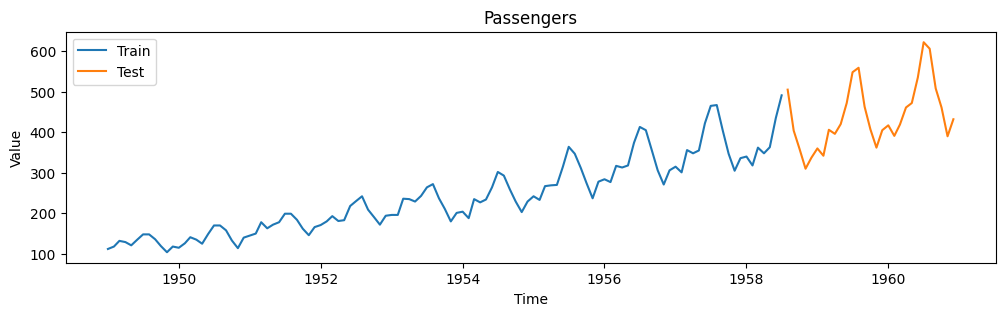

In [25]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.savefig("img/time_series_train_and_test.png", dpi = 300, bbox_inches='tight')  
plt.show() 

## ARIMA(p,d,q) Model

### Determinate $d$ Value

------------------------------ Diff i = 0 ------------------------------


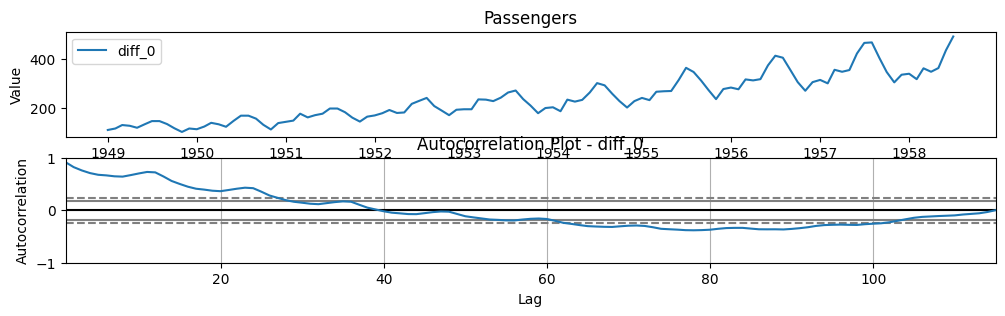

ADF Statistic: -0.3568892196404587
p-value: 0.9170517285875915
------------------------------ Diff i = 1 ------------------------------


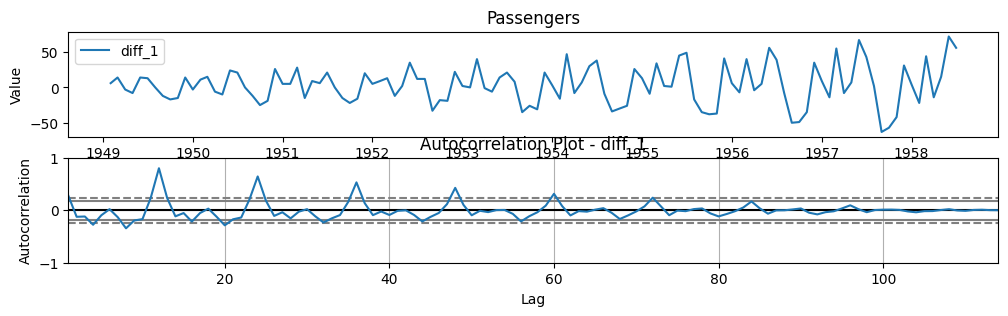

ADF Statistic: -2.53963478080807
p-value: 0.10612609999673994
------------------------------ Diff i = 2 ------------------------------


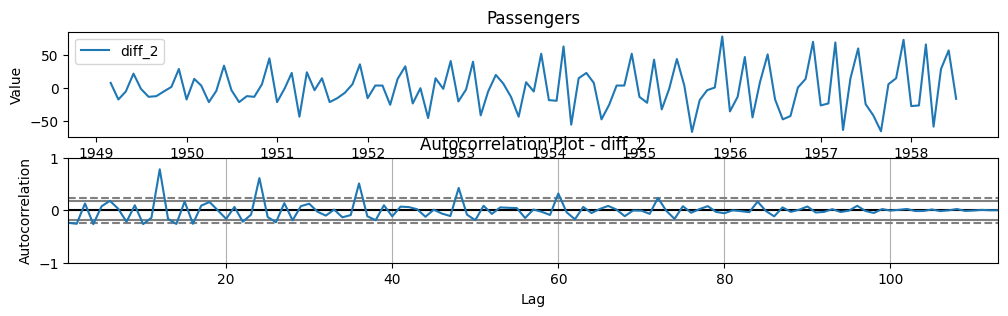

ADF Statistic: -6.932643663912723
p-value: 1.0742739510338154e-09


In [43]:
diff_list = [0,1,2]
for i in diff_list: 
    print("-"*30 + f" Diff i = {i} " + "-"*30)
    
    # Print Plot 
    if i == 0:
        train[f'{ts_variable}_diff_0'] = train[f'{ts_variable}']
    else:
        train[f'{ts_variable}_diff_{i}'] = train[f'{ts_variable}_diff_{i-1}'].diff()

    # Time Series Plot 
    plt.figure(figsize = (12,3))
    plt.subplot(2,1,1)
    plt.plot(train[date_variable], train[f'{ts_variable}_diff_{i}'] , label = f'diff_{i}')
    plt.title(f"{ts_variable}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()

    plt.subplot(2,1,2)
    # Autocorrelation Plot 
    # plt.figure(figsize = (12,3))
    autocorrelation_plot(train[f'{ts_variable}_diff_{i}'].dropna())
    plt.title(f"Autocorrelation Plot - diff_{i}")
    plt.show()

    # Augmented Dickey-Fulley Test
    result = adfuller(train[f'{ts_variable}_diff_{i}'].dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

At d=2 the stationality appears.

In [14]:
# Augmented Dickey-Fulley Test
result = adfuller(data[variable])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.804874441337736
p-value: 0.3780443683427438


In [18]:
train

,period,T (degC)
0,2009-01-01,-3.626617
1,2009-02-01,0.169950
2,2009-03-01,3.989944
3,2009-04-01,11.889757
4,2009-05-01,13.433905
...,...,...
72,2015-01-01,2.593551
73,2015-02-01,1.062059
74,2015-03-01,5.241246
75,2015-04-01,8.852567


High **p_value** the data isn't stationary so we apply differentiation. 

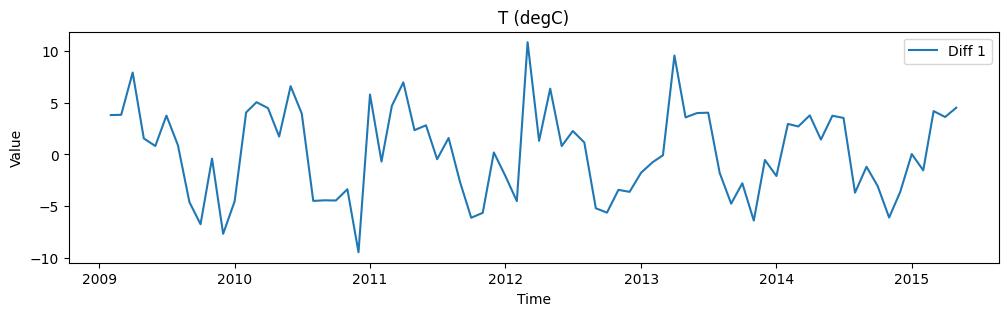

In [20]:
train[f'{variable}_diff_1'] = data[variable].diff()
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[f'{variable}_diff_1'] , label = f'Diff 1')
plt.title(f"{variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

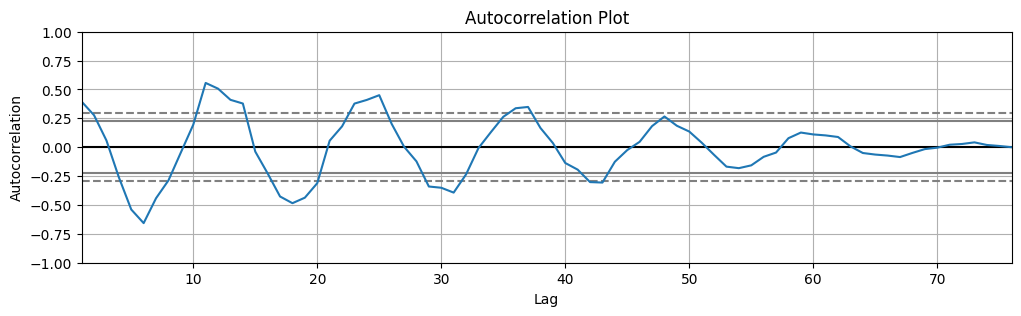

In [24]:
plt.figure(figsize = (12,3))
autocorrelation_plot(train[f'{variable}_diff_1'].dropna())
plt.title("Autocorrelation Plot")
plt.show()

### Determinate $q$ Value

## ARIMA 

In [77]:
# fit model
model_1 = ARIMA(train[variable], order=(10,1,0))
model_2 = ARIMA(train[variable], order=(10,2,0))
model_1_fit = model_1.fit()
model_2_fit = model_2.fit()

                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                   77
Model:                ARIMA(10, 1, 0)   Log Likelihood                -165.776
Date:                Tue, 11 Jun 2024   AIC                            353.552
Time:                        00:45:01   BIC                            379.190
Sample:                             0   HQIC                           363.798
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5668      0.117     -4.840      0.000      -0.796      -0.337
ar.L2         -0.3499      0.151     -2.312      0.021      -0.646      -0.053
ar.L3         -0.1922      0.129     -1.487      0.1

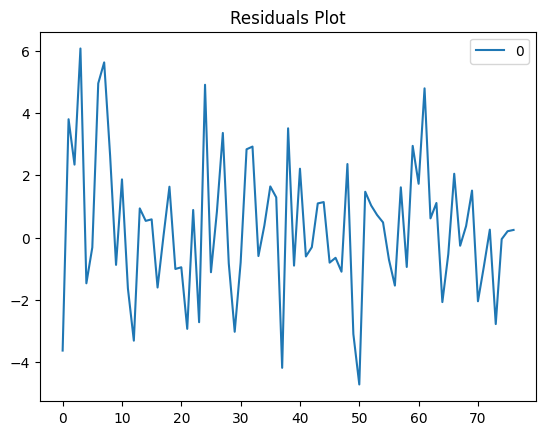

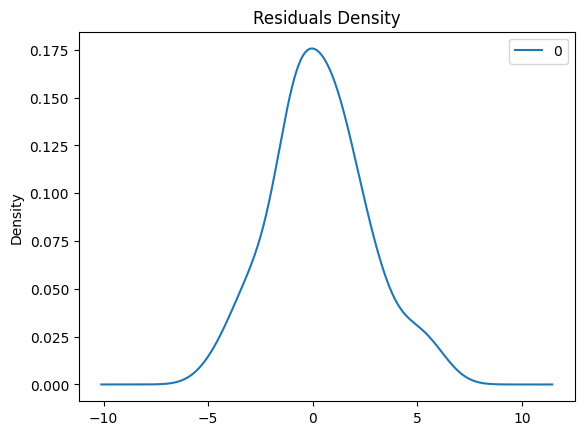

               0
count  77.000000
mean    0.343520
std     2.256900
min    -4.714640
25%    -0.943814
50%     0.253861
75%     1.631018
max     6.066734


In [78]:
# Summary of fit Model 
print(model_1_fit.summary())
# Residuals Plot
residuals = pd.DataFrame(model_1_fit.resid)
residuals.plot()
plt.title("Residuals Plot")
plt.show()
# Density plot Residuals
residuals.plot(kind='kde')
plt.title("Residuals Density")
plt.show()
# summary stats of residuals
print(residuals.describe())

In [81]:
train["prediction_order_1"] = model_1_fit.predict(start=0, end=len(train))
train["prediction_order_2"] = model_2_fit.predict(start=0, end=len(train))

test["prediction_order_1"] = model_1_fit.forecast(steps = len(test))
test["prediction_order_2"] = model_2_fit.forecast(steps = len(test))
test

,period,T (degC),prediction_order_1,prediction_order_2
77,2015-06-01,16.455951,17.652448,17.554935
78,2015-07-01,20.586064,17.886529,17.782398
79,2015-08-01,20.926499,18.048330,18.394618
80,2015-09-01,13.438380,15.665300,15.848130
81,2015-10-01,8.234736,11.074502,11.418155
82,2015-11-01,8.009806,6.545242,7.440818
83,2015-12-01,6.612672,3.851351,4.940327
84,2016-01-01,1.058154,1.544736,2.841971
85,2016-02-01,3.580045,2.282368,3.920861
86,2016-03-01,4.102914,4.837615,6.400966


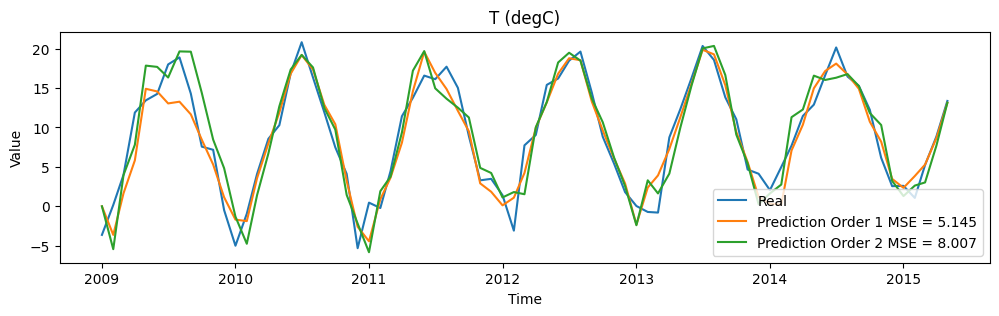

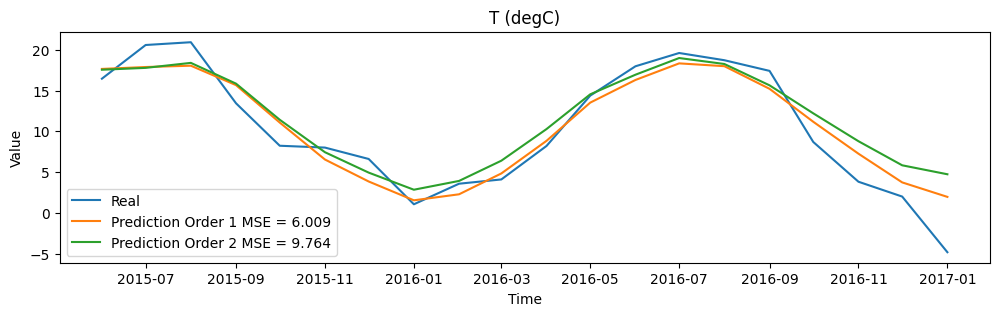

In [82]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[variable], label = f'Real')
plt.plot(train[date_variable], train["prediction_order_1"], label = f"Prediction Order 1 MSE = {round(mean_squared_error(train[variable], train['prediction_order_1']),3)}")
plt.plot(train[date_variable], train["prediction_order_2"], label = f"Prediction Order 2 MSE = {round(mean_squared_error(train[variable], train['prediction_order_2']),3)}")
plt.title(f"{variable} TRAIN")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

plt.figure(figsize=(12,3))
plt.plot(test[date_variable], test[variable], label = f'Real')
plt.plot(test[date_variable], test["prediction_order_1"], label = f"Prediction Order 1 MSE = {round(mean_squared_error(test[variable], test['prediction_order_1']),3)}")
plt.plot(test[date_variable], test["prediction_order_2"], label = f"Prediction Order 2 MSE = {round(mean_squared_error(test[variable], test['prediction_order_2']),3)}")
plt.title(f"{variable} TEST")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 